Author: Vinícius Tertulino Parede

Contact: vinicius.parede@ppgia.pucpr.br

# Libraries

In [31]:
import pandas as pd
import numpy as np

# Pre-processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Models Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn import tree

import matplotlib.pyplot as plt

# Load Data

In [32]:
# load data
csv_link = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(csv_link)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Statistical quantitative description of the category features

In [33]:
variables: list = ["anaemia", "high_blood_pressure", "diabetes", "sex", "smoking"]
summary_list: list = []

# Iterate over selected variables
for var in variables:
    # Calculate counts and percentages for the full sample
    full_sample_count = df[var].value_counts()
    full_sample_percent = df[var].value_counts(normalize=True) * 100

    # Calculate counts and percentages for patients who died
    dead_sample_count = df[df["DEATH_EVENT"] == 1][var].value_counts()
    dead_sample_percent = (
        df[df["DEATH_EVENT"] == 1][var].value_counts(normalize=True) * 100
    )

    # Calculate counts and percentages for patients who survived
    survived_sample_count = df[df["DEATH_EVENT"] == 0][var].value_counts()
    survived_sample_percent = (
        df[df["DEATH_EVENT"] == 0][var].value_counts(normalize=True) * 100
    )

    # Create temporary DataFrame for each variable and value
    for val in [0, 1]:
        temp_df = pd.DataFrame(
            {
                "Variable": var,
                "Bool": val,
                "Full Sample #": full_sample_count.get(val, 0),
                "Full Sample %": full_sample_percent.get(val, 0),
                "Dead Patients #": dead_sample_count.get(val, 0),
                "Dead Patients %": dead_sample_percent.get(val, 0),
                "Survived Patients #": survived_sample_count.get(val, 0),
                "Survived Patients %": survived_sample_percent.get(val, 0),
            },
            index=[0],
        )
        summary_list.append(temp_df)

# Concatenate all temporary DataFrames into a single summary DataFrame
pd.concat(summary_list, ignore_index=True).round(2)

,Variable,Bool,Full Sample #,Full Sample %,Dead Patients #,Dead Patients %,Survived Patients #,Survived Patients %
0,anaemia,0,170,56.86,50,52.08,120,59.11
1,anaemia,1,129,43.14,46,47.92,83,40.89
2,high_blood_pressure,0,194,64.88,57,59.38,137,67.49
3,high_blood_pressure,1,105,35.12,39,40.62,66,32.51
4,diabetes,0,174,58.19,56,58.33,118,58.13
5,diabetes,1,125,41.81,40,41.67,85,41.87
6,sex,0,105,35.12,34,35.42,71,34.98
7,sex,1,194,64.88,62,64.58,132,65.02
8,smoking,0,203,67.89,66,68.75,137,67.49
9,smoking,1,96,32.11,30,31.25,66,32.51


# Statistical quantitative description of the numeric features

In [34]:
variables = [
    "age",
    "creatinine_phosphokinase",
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "time",
    "DEATH_EVENT",
]


full_sample = df.loc[:, variables].copy()
dead_sample = full_sample.loc[full_sample["DEATH_EVENT"] == 1].copy()
survived_sample = full_sample.loc[full_sample["DEATH_EVENT"] == 0].copy()

full_sample.drop(columns="DEATH_EVENT", inplace=True)
dead_sample.drop(columns="DEATH_EVENT", inplace=True)
survived_sample.drop(columns="DEATH_EVENT", inplace=True)

variables = variables.remove("DEATH_EVENT")

statistics = ["50%", "mean", "std"]
statistics_full_sample = full_sample.describe().T.loc[:, statistics].copy()
statistics_dead_sample = dead_sample.describe().T.loc[:, statistics].copy()
statistics_survived_sample = survived_sample.describe().T.loc[:, statistics].copy()

statistics_full_sample.rename(
    columns={
        "50%": "Full Sample Median",
        "mean": "Full Sample Mean",
        "std": "Full Sample Standard Deviation",
    },
    inplace=True,
)
statistics_dead_sample.rename(
    columns={
        "50%": "Dead Patients Median",
        "mean": "Dead Patients Mean",
        "std": "Dead Patients Standard Deviation",
    },
    inplace=True,
)
statistics_survived_sample.rename(
    columns={
        "50%": "Survived Patients Median",
        "mean": "Survived Patients Mean",
        "std": "Survived Patients Standard Deviation",
    },
    inplace=True,
)

pd.concat(
    [statistics_full_sample, statistics_dead_sample, statistics_survived_sample], axis=1
).round(2)

,Full Sample Median,Full Sample Mean,Full Sample Standard Deviation,Dead Patients Median,Dead Patients Mean,Dead Patients Standard Deviation,Survived Patients Median,Survived Patients Mean,Survived Patients Standard Deviation
age,60.0,60.83,11.89,65.0,65.22,13.21,60.0,58.76,10.64
creatinine_phosphokinase,250.0,581.84,970.29,259.0,670.20,1316.58,245.0,540.05,753.80
ejection_fraction,38.0,38.08,11.83,30.0,33.47,12.53,38.0,40.27,10.86
platelets,262000.0,263358.03,97804.24,258500.0,256381.04,98525.68,263000.0,266657.49,97531.20
serum_creatinine,1.1,1.39,1.03,1.3,1.84,1.47,1.0,1.18,0.65
serum_sodium,137.0,136.63,4.41,135.5,135.38,5.00,137.0,137.22,3.98
time,115.0,130.26,77.61,44.5,70.89,62.38,172.0,158.34,67.74


# A) Model Construction
Find the best solution for this problem through the evaluation of monolithic solutions (using a single model). For this, evaluate the techniques studied in class (KNN, Naive Bayes, Decision Trees, SVM and MLP). Use cross-validation considering 5 folds. Record in the table below the model with the best result, give preference to the most suitable metric considering the problem at hand.

## Preprocessing Data

In [35]:
columns = df.columns
target = "DEATH_EVENT"
features = columns.drop(target)

# Specify the columns that are the independent variables (X) and the dependent variable (y)
X = df.loc[:, features].copy()
y = df.loc[:, target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dataset: ", X.shape[0])
print("Train  : ", X_train.shape[0])
print("Test   : ", X_test.shape[0])

Dataset:  299
Train  :  239
Test   :  60


## Model Selection

In [36]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
def find_best_model(X, y):
    models = {
        "KNN": (
            KNeighborsClassifier(),
            {
                "classifier__n_neighbors": [1, 3, 5, 7, 9, 11, 13],
                "classifier__weights": ["uniform", "distance"],
                "classifier__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                "classifier__leaf_size": [10, 30, 50],
            },
        ),
        "Naive Bayes": (
            GaussianNB(),
            {
                "classifier__var_smoothing": [1e-9, 1e-8, 1e-7],
            },
        ),
        "Decision Tree": (
            DecisionTreeClassifier(),
            {
                "classifier__ccp_alpha": [0.01, 0.1, 0.2],
                "classifier__criterion": ["gini", "entropy"],
                "classifier__max_depth": [None, 3, 5, 6, 10],
                "classifier__max_features": [None, "sqrt", "log2"],
                "classifier__min_samples_split": [2, 4, 6],
                "classifier__splitter": ["best", "random"],
            },
        ),
        "SVM": (
            svm.SVC(),
            {
                "classifier__C": [0.1, 1, 10, 100],
                "classifier__gamma": ["scale", "auto", 1, 0.1, 0.01],
                "classifier__kernel": ["linear", "rbf", "poly", "sigmoid"],
                "classifier__degree": [
                    2,
                    3,
                    4,
                    5,
                ],
            },
        ),
        "MLP": (
            MLPClassifier(),
            {
                "classifier__hidden_layer_sizes": [(100,), (200,), (300,), (100, 100)],
                "classifier__activation": ["relu", "tanh", "logistic", "identity"],
                "classifier__solver": ["lbfgs", "sgd", "adam"],
                "classifier__max_iter": [10000],
                "classifier__alpha": [0.0001, 0.001, 0.01, 0.1],
                "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
            },
        ),
        "Random Forest": (
            RandomForestClassifier(),
            {
                "classifier__n_estimators": [100, 200, 500],
                "classifier__criterion": ["gini", "entropy"],
                "classifier__max_depth": [None, 3, 5, 10],
                "classifier__max_features": ["sqrt", "log2"],
                "classifier__min_samples_split": [2, 4, 6],
            },
        ),
        "AdaBoost": (
            AdaBoostClassifier(),
            {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__learning_rate": [0.1, 0.5, 1.0],
            },
        ),
        "Gradient Boosting": (
            GradientBoostingClassifier(),
            {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__learning_rate": [0.1, 0.5, 1.0],
                "classifier__max_depth": [3, 5, 10],
                "classifier__max_features": ["sqrt", "log2"],
            },
        ),
        "HistGradient Boosting": (
            HistGradientBoostingClassifier(),
            {
                "classifier__learning_rate": [0.1, 0.5, 1.0],
                "classifier__max_iter": [100, 200, 500],
                "classifier__max_depth": [None, 3, 5, 10],
                "classifier__max_leaf_nodes": [None, 10, 50, 100],
            },
        ),
    }

    best_models = {}
    for name_model, (model, params) in models.items():
        pipeline = Pipeline([("scaler", StandardScaler()), ("classifier", model)])
        gs = GridSearchCV(
            estimator=pipeline, param_grid=params, cv=cv, scoring="recall", n_jobs=-1
        )
        gs.fit(X, y)

        recall = cross_val_score(
            gs.best_estimator_, X, y, cv=cv, scoring="recall", n_jobs=-1
        ).mean()

        precision = cross_val_score(
            gs.best_estimator_, X, y, cv=cv, scoring="precision"
        ).mean()

        f1_score = cross_val_score(
            gs.best_estimator_, X, y, cv=cv, scoring="f1", n_jobs=-1
        ).mean()

        accuracy = cross_val_score(
            gs.best_estimator_, X, y, cv=cv, scoring="accuracy", n_jobs=-1
        ).mean()

        best_models[name_model] = {
            "best_estimator": gs.best_estimator_,
            "recall": recall,
            "precision": precision,
            "f1_score": f1_score,
            "accuracy": accuracy,
        }

    return best_models


best_models = find_best_model(X=X_train, y=y_train)
best_models_df = pd.DataFrame(best_models)
best_models_df.round(2)

/home/vinicius/repositories/heart-failure-predict/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,KNN,Naive Bayes,Decision Tree,SVM,MLP,Random Forest,AdaBoost,Gradient Boosting,HistGradient Boosting
best_estimator,"(StandardScaler(), KNeighborsClassifier(leaf_s...","(StandardScaler(), GaussianNB())","(StandardScaler(), DecisionTreeClassifier(ccp_...","(StandardScaler(), SVC(C=1, degree=2, gamma=0....","(StandardScaler(), MLPClassifier(alpha=0.01, h...","(StandardScaler(), (DecisionTreeClassifier(max...","(StandardScaler(), (DecisionTreeClassifier(max...","(StandardScaler(), ([DecisionTreeRegressor(cri...","(StandardScaler(), HistGradientBoostingClassif..."
recall,0.332925,0.525475,0.681918,0.753111,0.217942,0.780888,0.735137,0.720362,0.70729
precision,0.572857,0.655714,0.65683,0.76423,0.244642,0.802143,0.795317,0.801557,0.726984
f1_score,0.402712,0.564089,0.677664,0.754244,0.297538,0.778084,0.753651,0.719229,0.699121
accuracy,0.727926,0.778014,0.823936,0.857358,0.392996,0.870124,0.861525,0.849202,0.83227


In [38]:
best_models_df.iloc[2].to_dict()

{'KNN': 0.5728571428571428,
 'Naive Bayes': 0.6557142857142857,
 'Decision Tree': 0.6568300653594772,
 'SVM': 0.7642296918767507,
 'MLP': 0.24464237516869095,
 'Random Forest': 0.8021428571428573,
 'AdaBoost': 0.7953174603174602,
 'Gradient Boosting': 0.8015567765567766,
 'HistGradient Boosting': 0.726984126984127}

In [39]:
data = best_models_df.iloc[2].to_dict()
best_model_name = max(data, key=data.get)
best_model = best_models_df[best_model_name]["best_estimator"]
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        min_samples_split=4))])

# B) Respond based on the studied techniques and observed results:

## B.1) How many instances are there in the database provided by the company?

In [40]:
print("Instances: ", X.shape[0])

Instances:  299


## B.2) How many input attributes form each instance of the database?

In [41]:
print("Attributes: ", X.shape[1])

Attributes:  12


## B.3) How many examples of each class are there in the database?

In [42]:
print("Survived patients: ", df.loc[df[target] == 0].shape[0])
print("Death patients   : ", df.loc[df[target] == 1].shape[0])

Survived patients:  203
Death patients   :  96


## B.4) In the table above, you presented your best model. Justify your choice

When selecting the best model, it is crucial to carefully consider performance metrics that are relevant to the specific problem at hand. In the medical field, where precision and reliability are of utmost importance, the Recall metric plays a vital role in evaluating model performance. In this context, minimizing the number of false negatives (FN) is essential, as these errors can lead to serious complications for patients.

Recall is a metric that quantifies a model's ability to correctly identify positive instances, i.e., cases that genuinely require attention or action. In a medical scenario, false negatives refer to cases where the model failed to correctly identify a condition or disease present in a patient. These errors can have severe consequences, such as delayed diagnoses, inadequate or delayed treatments, and in extreme cases, even endangering the patient's life.

By prioritizing the Recall metric when choosing the best model, we ensure that the system is capable of identifying the majority of positive cases, thus minimizing the occurrence of false negatives. This is crucial in the medical field, where early and accurate detection of health conditions is of vital importance.

While precision (a metric that assesses the proportion of correctly classified positive instances) is also relevant, choosing a model based solely on precision can lead to a high rate of false negatives, which represents a significant risk in medicine.

Therefore, considering the direct implications for patient health and well-being, the choice of the best model based on the Recall metric is justified, as this approach seeks to minimize FN errors, thereby reducing the risk of serious complications and providing safer and more effective medical care.

## B.5) Please present the confusion matrix of the model indicated in the table and fill it out below:

In [43]:
print("\nValidation Confusion Matrix\n")


y_pred = cross_val_predict(estimator=best_model, X=X_train, y=y_train, cv=cv)

cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
print(cm)

print(
    classification_report(
        y_true=y_train,
        y_pred=y_pred,
        target_names=["No Heart Failure", "Heart Failure"],
    )
)

tn, fp, fn, tp = cm.ravel()

print("\nTrue Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)
print("")

tvp = tp / (tp + fn)
tfp = fp / (fp + tn)
tvn = tn / (tn + fp)
tfn = fn / (fn + tp)

print("True Positive Rate (TVP):", np.round(tvp, 2))
print("False Positive Rate (TFP):", np.round(tfp, 2))
print("True Negative Rate (TVN):", np.round(tvn, 2))
print("False Negative Rate (TFN):", np.round(tfn, 2))

heart_failure_training = tvp
normal_training = tvn


print("\n===========================================\n")


print("Test Confusion Matrix\n")

y_pred = cross_val_predict(estimator=best_model, X=X_test, y=y_test, cv=5)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cm)

print(
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
        target_names=["No Heart Failure", "Heart Failure"],
    )
)

tn, fp, fn, tp = cm.ravel()

print("\nTrue Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)
print("")

tvp = tp / (tp + fn)
tfp = fp / (fp + tn)
tvn = tn / (tn + fp)
tfn = fn / (fn + tp)

print("True Positive Rate (TVP):", np.round(tvp, 2))
print("False Positive Rate (TFP):", np.round(tfp, 2))
print("True Negative Rate (TVN):", np.round(tvn, 2))
print("False Negative Rate (TFN):", np.round(tfn, 2))

heart_failure_test = tvp
normal_test = tvn


Validation Confusion Matrix

[[157  11]
 [ 17  54]]
                  precision    recall  f1-score   support

No Heart Failure       0.90      0.93      0.92       168
   Heart Failure       0.83      0.76      0.79        71

        accuracy                           0.88       239
       macro avg       0.87      0.85      0.86       239
    weighted avg       0.88      0.88      0.88       239


True Positive (TP): 54
False Positive (FP): 11
True Negative (TN): 157
False Negative (FN): 17

True Positive Rate (TVP): 0.76
False Positive Rate (TFP): 0.07
True Negative Rate (TVN): 0.93
False Negative Rate (TFN): 0.24


Test Confusion Matrix

[[28  7]
 [11 14]]
                  precision    recall  f1-score   support

No Heart Failure       0.72      0.80      0.76        35
   Heart Failure       0.67      0.56      0.61        25

        accuracy                           0.70        60
       macro avg       0.69      0.68      0.68        60
    weighted avg       0.70      0.70

## B.6) Based on the confusion matrix presented in B.5, calculate the accuracy rate per class.

In [44]:
print("Heart Failure Training    :", np.round(heart_failure_training, 2))
print("No Heart Failure Training :", np.round(normal_training, 2))
print("Heart Failure Test        :", np.round(heart_failure_test, 2))
print("No Heart Failure Test     :", np.round(normal_test, 2))

Heart Failure Training    : 0.76
No Heart Failure Training : 0.93
Heart Failure Test        : 0.56
No Heart Failure Test     : 0.8


## B.7) Among the evaluated white-box models, which one performed the best? Show the results (accuracy rate and F1 score).

In [45]:
white_box_models = ["KNN", "Naive Bayes", "Decision Tree"]

white_models = {model: best_models.get(model) for model in white_box_models}

best_white_model = max(white_models.values(), key=lambda x: x["accuracy"])

best_white_model

{'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                 ('classifier',
                  DecisionTreeClassifier(ccp_alpha=0.01, max_depth=6,
                                         max_features='sqrt'))]),
 'recall': 0.6819180303700427,
 'precision': 0.6568300653594772,
 'f1_score': 0.6776635720601238,
 'accuracy': 0.823936170212766}

## B.8) Considering the use of decision tree for this problem, which attribute was the most important according to this technique?

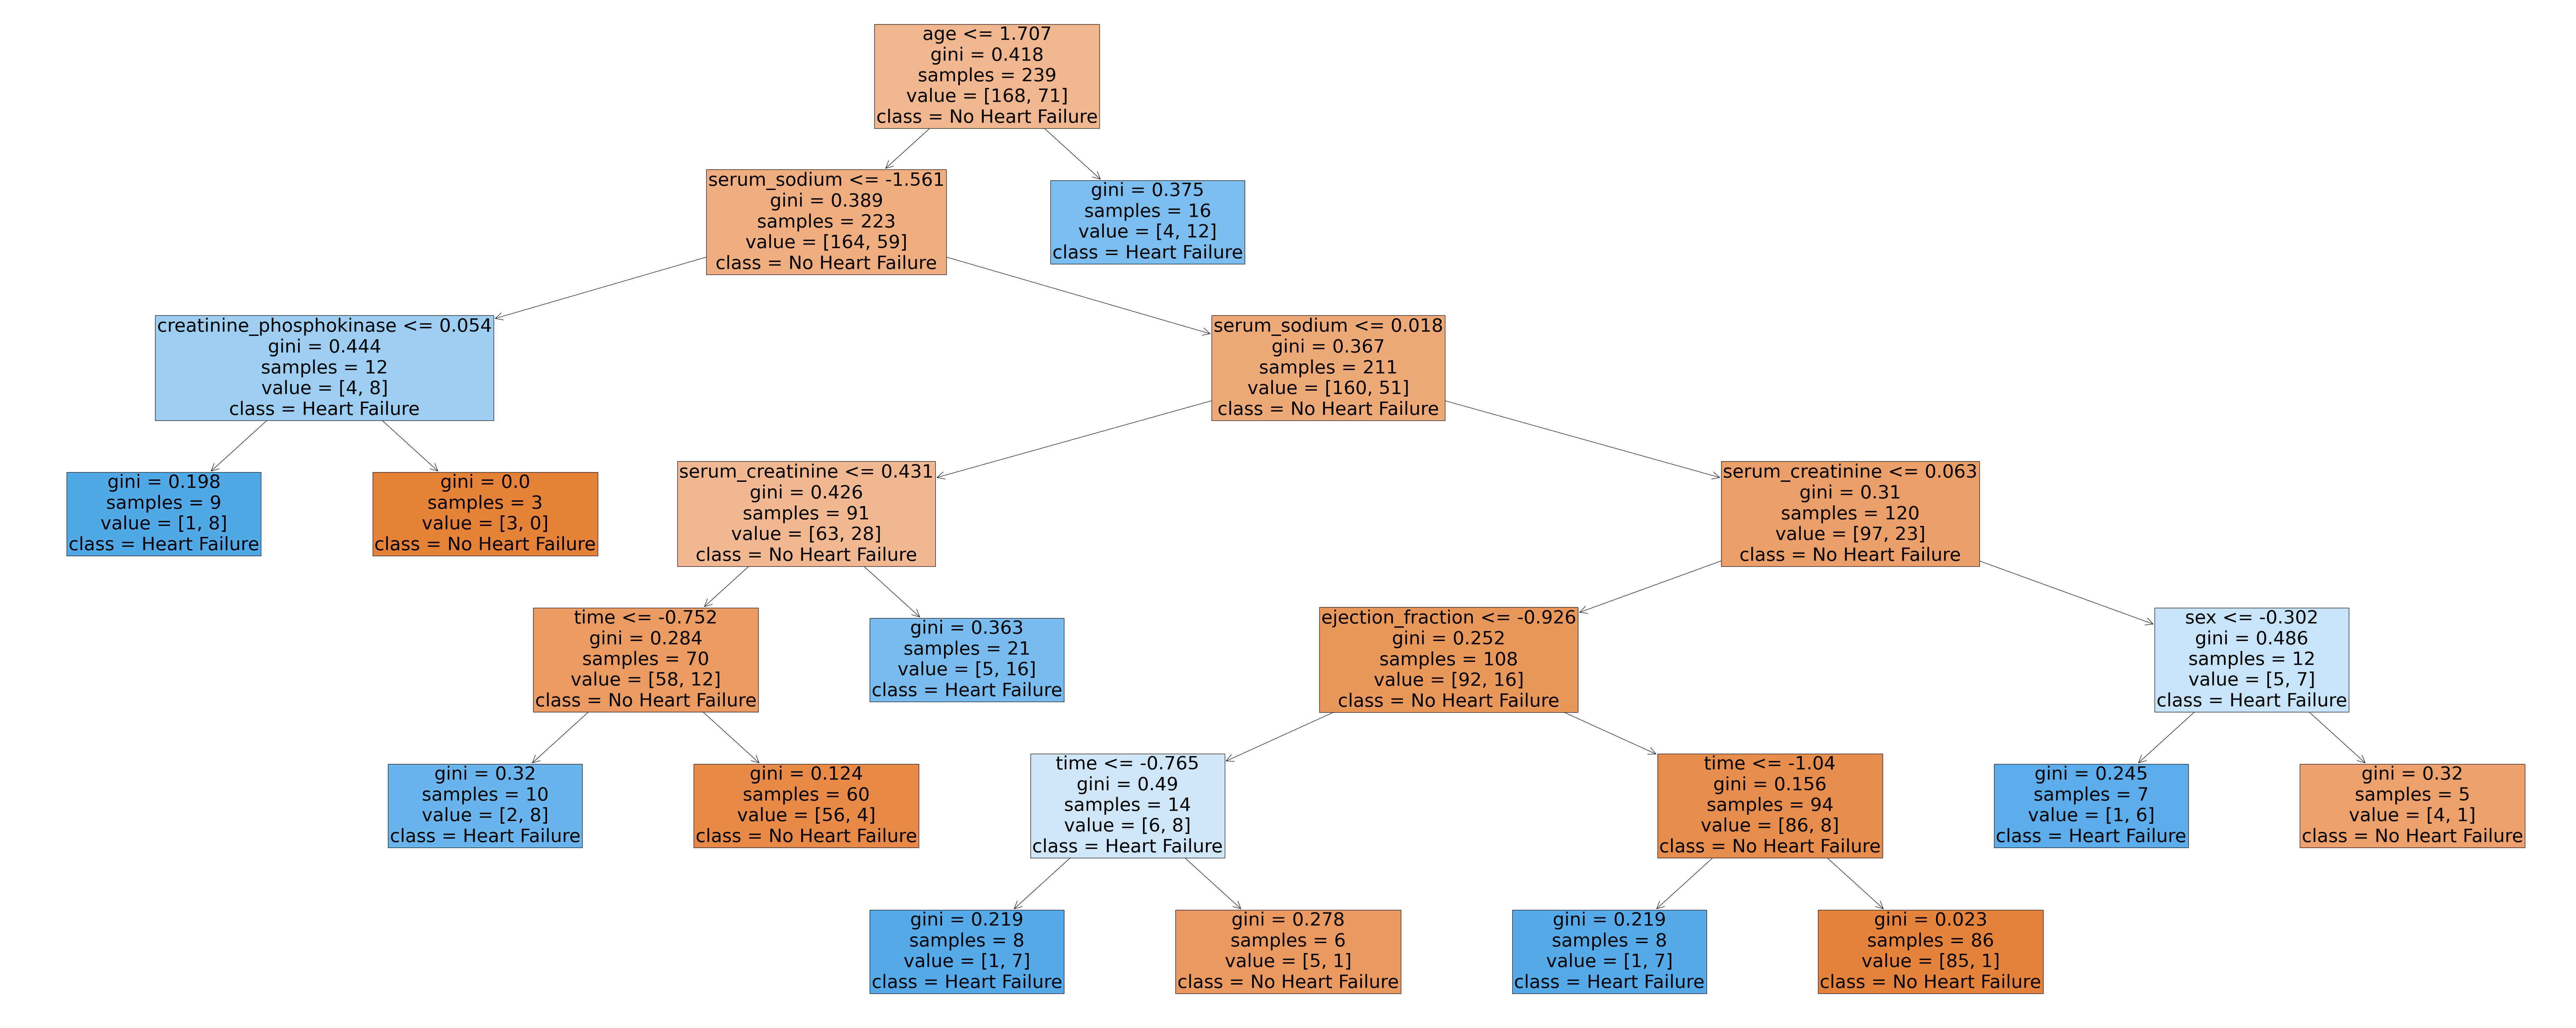

In [46]:
class_names = ["No Heart Failure", "Heart Failure"]
y_train_named = y_train.replace({0: class_names[0], 1: class_names[1]})


_, ax = plt.subplots(figsize=(100, 40))
x = tree.plot_tree(
    best_models_df["Decision Tree"]["best_estimator"]["classifier"],
    feature_names=X_train.columns,
    class_names=class_names,
    filled=True,
    ax=ax,
    fontsize=40,
)

Attribute "ejection_fraction"

## B.9) Among the studied models, which one aims to define a hyperplane between two classes in order to maximize the margin of separation between them?

Among the studied models, the Support Vector Machine (SVM) aims to define a hyperplane between two classes in order to maximize the margin of separation between them. SVM is a powerful classification algorithm that seeks to find an optimal hyperplane that can effectively separate the data points of different classes while maximizing the distance between the hyperplane and the nearest data points from each class. This margin maximization helps in achieving better generalization and robustness of the model.

## B.10) Explain how the Naive Bayes technique can be considered a simplification of Bayes' Theorem.

The Naive Bayes technique can be considered as a simplification of Bayes' Theorem.

Bayes' Theorem is a fundamental principle in probability theory that describes how to update the probability of a hypothesis given new evidence. It calculates the conditional probability of a hypothesis (or an event) based on prior knowledge and observed evidence. Bayes' Theorem involves calculating probabilities using joint probabilities and conditional probabilities.

Naive Bayes, on the other hand, is a specific machine learning algorithm that is based on Bayes' Theorem. It simplifies the calculation by making a strong assumption of conditional independence among the features or attributes. This assumption implies that the presence or absence of a particular feature does not affect the presence or absence of other features.

By assuming independence among the features, Naive Bayes can calculate the posterior probability of a class given the observed evidence using simple multiplications of individual conditional probabilities. This simplifies the computation and allows for efficient and fast learning from large datasets.